In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import autoencoder.helpers as helpers
from autoencoder.neuralnet import NeuralNetwork
from autoencoder.layers import (
  LinearLayer,
  SigmoidLayer,
  TanhLayer,
  ReluLayer,
  MSEOutputLayer
)

import tikhonov
from utils import avgn_attack, ssim, mse

In [2]:
shape=(28, 28)

In [3]:
def compare_denoised_images(images_true, images_noisy, denoised_samples, num_samples=8, idx=0, shape=(28, 28)):
  images_true_ = images_true[idx:idx+num_samples]
  images_noisy_ = images_noisy[idx:idx+num_samples]
  denoised_samples_ =  denoised_samples[idx:idx+num_samples]
  print(denoised_samples_.shape)
  fig, axs = plt.subplots(3, num_samples, figsize=(45, 15), gridspec_kw={'hspace': 0, 'wspace': -0.2})
  axs_ = axs.ravel()

  for i, (ts, ns, ds) in enumerate(zip(images_true_, images_noisy_, denoised_samples_)):
    axs_[i].axis('off')
    axs_[(num_samples) + i].axis('off')
    axs_[(2 * num_samples) + i].axis('off')    

    axs_[i].imshow(ts.reshape(shape), cmap="gray")
    axs_[(num_samples) + i].imshow(ns.reshape(shape), cmap="gray")
    axs_[(2 * num_samples) + i].imshow(ds.reshape(shape), cmap="gray")
    axs_[i].set_ylabel("asd")
  fig.savefig("images/autoencoder-denoising-samples.pdf", transparent=True, bbox_inches='tight', pad_inches=0)

In [4]:
def compare_tikhonov_autoencoder_ssim(clean_images, noisy_images, tikhonov_images, autoencoder_images, idx=0, figsize=(12, 12), shape=(28, 28)):
  (clean_image, noisy_image, tikhonov_image, autoencoder_image) = \
    (clean_images[idx].reshape(shape),
     noisy_images[idx].reshape(shape),
     tikhonov_images[idx].reshape(shape),
     autoencoder_images[idx].reshape(shape))
 
  fig, axs = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'hspace': 0.15, 'wspace': -0.125})
  axs_ = axs.ravel()

  imgs_info = [
    {'name': 'Чисте зображення', 'img': clean_image, 'ssim': ssim(clean_image, clean_image)},
    {'name': 'Пошкоджене зображення', 'img': noisy_image, 'ssim': ssim(clean_image, noisy_image)},
    {'name': 'Регуляризація Тіхонова', 'img': tikhonov_image, 'ssim': ssim(clean_image, tikhonov_image)},
    {'name': 'Автоенкодер', 'img': autoencoder_image, 'ssim': ssim(clean_image, autoencoder_image)},
  ]

  for ax, img_info in zip(axs_, imgs_info):
    ax.imshow(img_info['img'], 'gray')
    ax.axis('off')
    ax.set_title(f"{img_info['name']}\n SSIM: {np.round(img_info['ssim'], 3)}", fontsize=15)
  
  fig.savefig('images/denoising-methods-comparation.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [5]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(-1, 28*28) / 255
X_test = X_test.reshape(-1, 28*28) / 255

In [6]:
X_train_noisy = np.array([avgn_attack(x, 0.5, 0) for x in X_train])
X_test_noisy = np.array([avgn_attack(x, 0.5, 0) for x in X_test])
X_test_denoised_tikhonov = tikhonov.tikhonov_denoise_images(X_test_noisy, 0.55, 100)

In [7]:
prefix = "denoising-awgn-05-100-iter-128-batch"
new_layers = helpers.load_model(prefix)
net = NeuralNetwork()
net.load_layers(new_layers)
X_test_denoised_autoencoder = net.forward_step(X_test_noisy)[-1]

(8, 784)


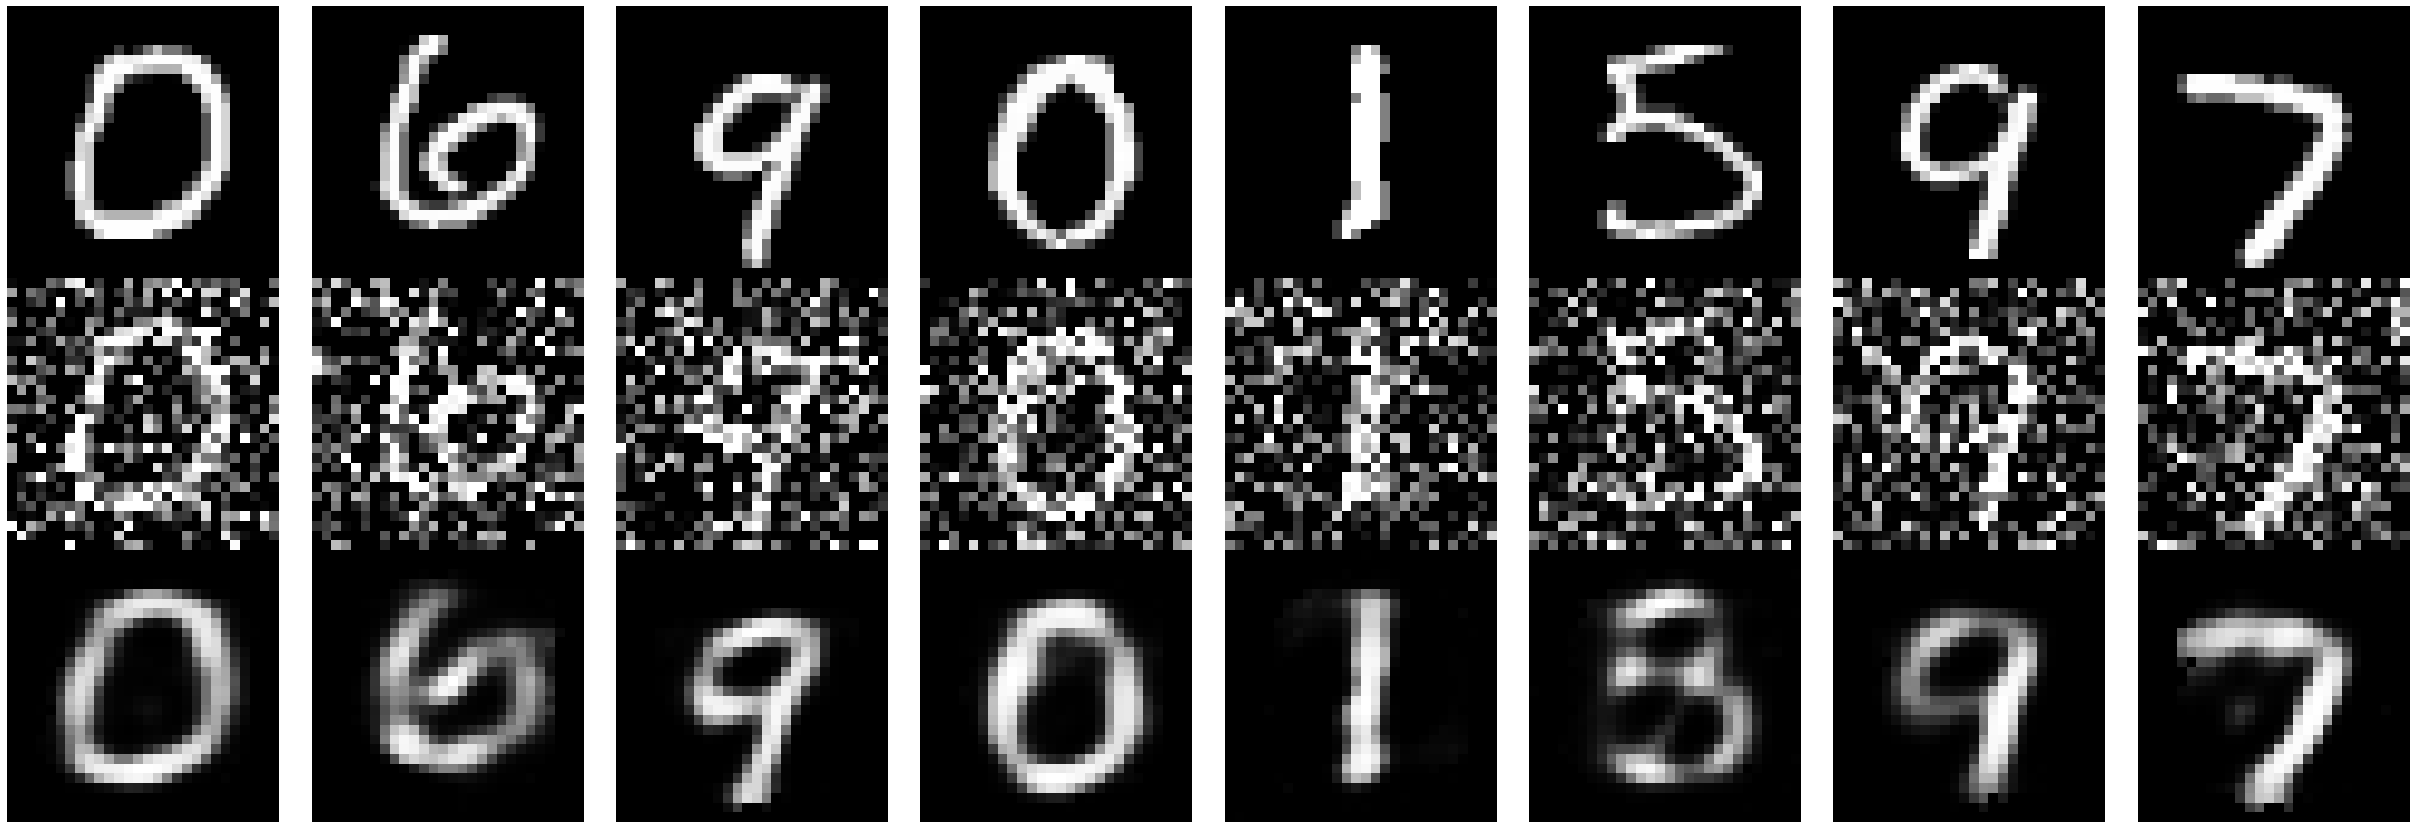

In [61]:
compare_denoised_images(X_test, X_test_noisy, X_test_denoised_autoencoder, idx=10)

In [9]:
X_test_denoised_tikhonov = tikhonov.tikhonov_denoise_images(X_test_noisy, 0.25, 100)

(8, 784)


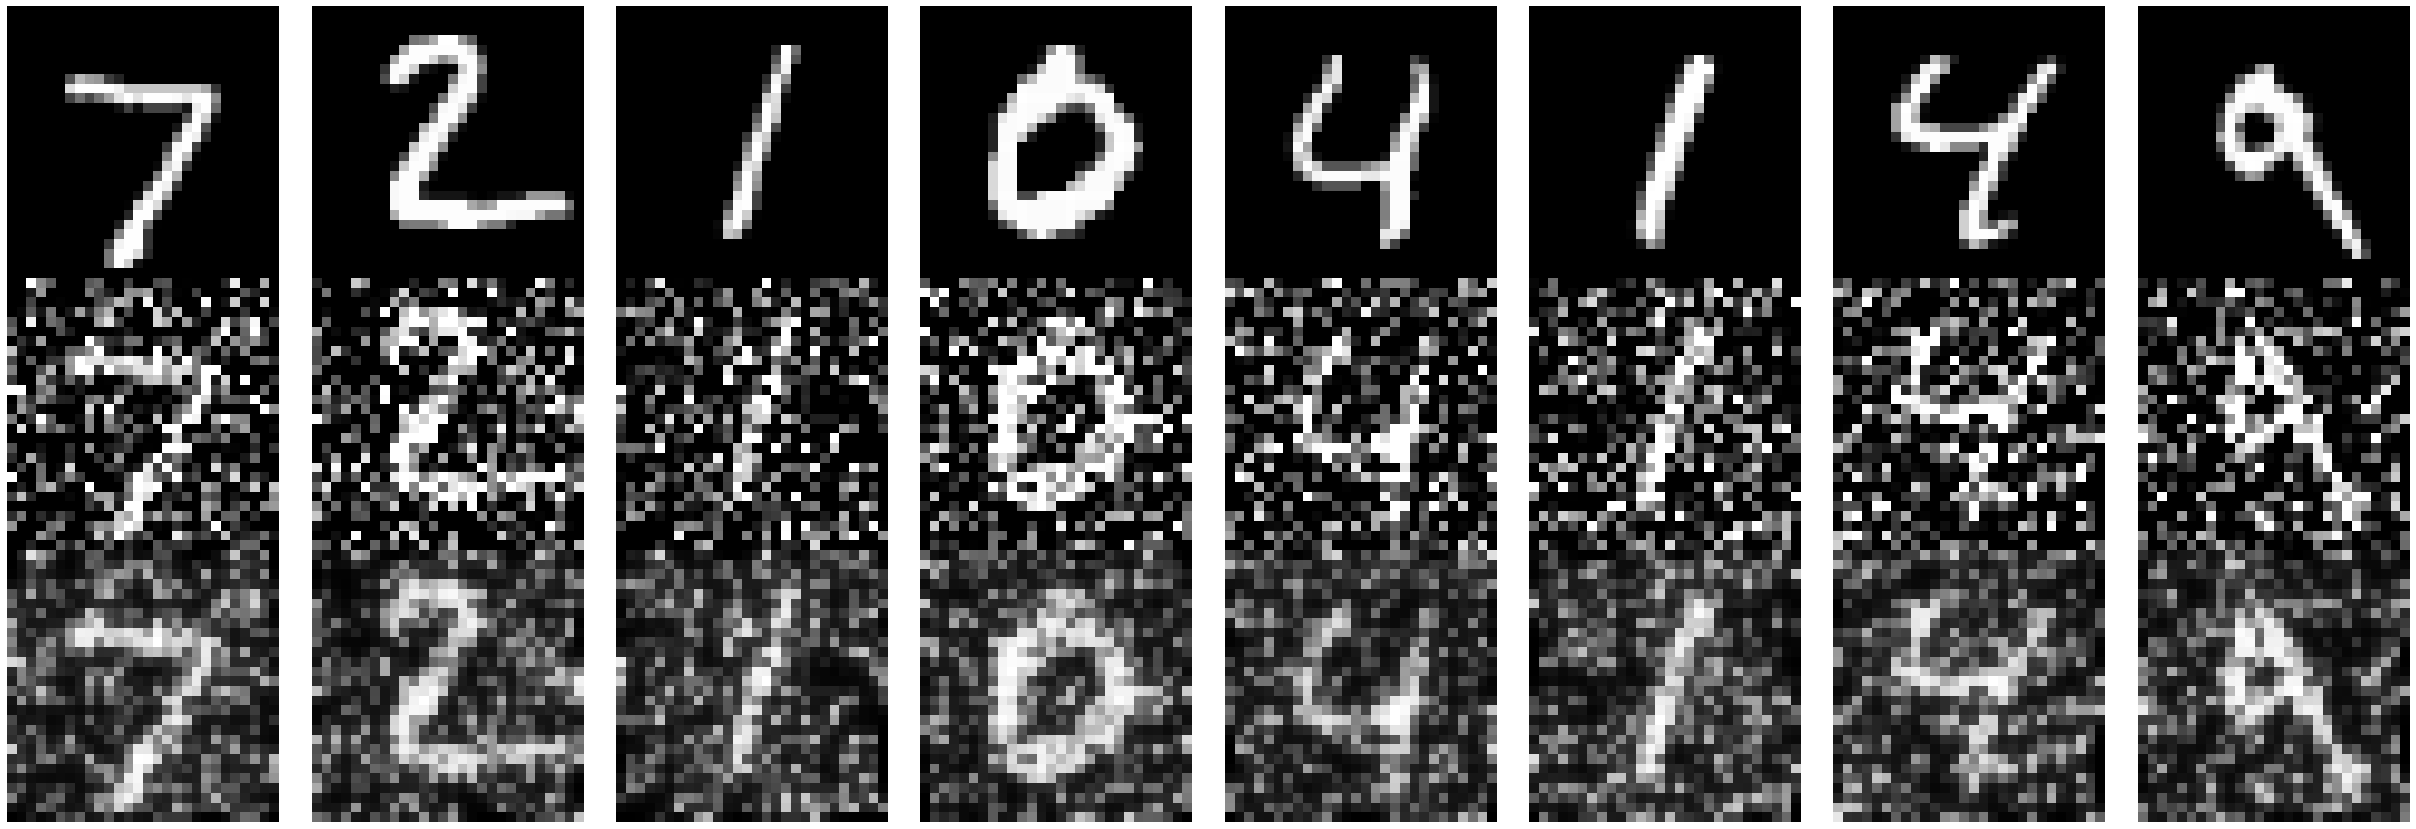

In [10]:
compare_denoised_images(X_test, X_test_noisy, X_test_denoised_tikhonov)

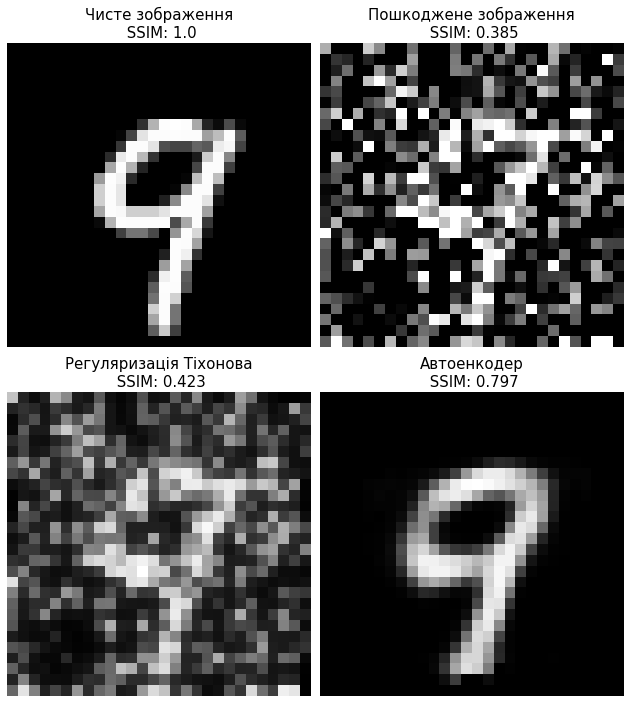

In [11]:
compare_tikhonov_autoencoder_ssim(X_test, X_test_noisy, X_test_denoised_tikhonov, X_test_denoised_autoencoder, idx=12)

In [12]:
ssim_cost = [ssim(x_noisy, x_clean) for x_noisy, x_clean in zip(X_test[0:100], X_test_denoised_autoencoder[0:100])]

In [13]:
print(np.min(ssim_cost), np.mean(ssim_cost), np.max(ssim_cost))
# min avg max
# 30 iter
# 0.19016236066818237 0.5795038694143295 0.876566469669342

0.24023564159870148 0.6420442275702953 0.9283152222633362


In [14]:
mse(X_test[0:10], X_test_denoised_autoencoder[0:10])

0.021950818927575076

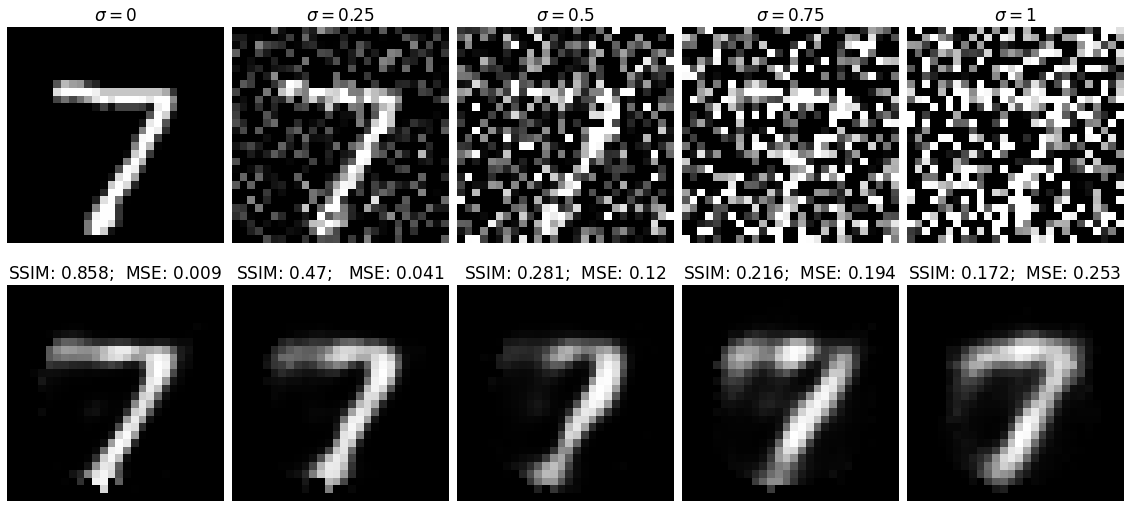

In [62]:
def compare_denoising_for_awgn(X_test, figsize=(20, 10), idx=0, shape=(28, 28)):
  dnn_details = [
    {"name": "denoising-awgn-00-35-iter-128-batch", "noise_factor": 0, "net": None, "noisy": None, "denoised": None},
    {"name": "denoising-awgn-025-35-iter-128-batch", "noise_factor": 0.25, "net": None, "noisy": None, "denoised": None},
    {"name": "denoising-awgn-05-35-iter-128-batch", "noise_factor": 0.50, "net": None, "noisy": None, "denoised": None},
    {"name": "denoising-awgn-075-35-iter-128-batch", "noise_factor": 0.75, "net": None, "noisy": None, "denoised": None},
    {"name": "denoising-awgn-1-35-iter-128-batch", "noise_factor": 1, "net": None, "noisy": None, "denoised": None}
  ]
  
  for dnn in dnn_details:
    layers = helpers.load_model(dnn["name"])
    net = NeuralNetwork()
    net.load_layers(layers)

    dnn["net"] = net
    dnn["noisy"] = avgn_attack(X_test[idx], dnn['noise_factor'], 0)
    dnn["denoised"] = net.forward_step(dnn["noisy"])[-1]
    
  fig, axs = plt.subplots(2, 5, figsize=figsize, gridspec_kw={'hspace': -0.1, 'wspace': 0.04})
  axs_ = axs.ravel()

  for i, (ax, dnn) in enumerate(zip(axs_, dnn_details)):
    axs_[i].set_title(f"$\sigma={dnn['noise_factor']}$", fontsize=17)
    axs_[len(dnn_details) + i].set_title(f"SSIM: ${np.round(ssim(dnn['noisy'], dnn['denoised']), 3)}$; \t" + \
                                         f"MSE: ${np.round(mse(dnn['noisy'], dnn['denoised']), 3)}$", fontsize=17)
    
    axs_[i].imshow(dnn['noisy'].reshape(shape), 'gray')
    axs_[len(dnn_details) + i].imshow(dnn['denoised'].reshape(shape), 'gray')

    axs_[i].axis('off')
    axs_[len(dnn_details) + i].axis('off')
    
    fig.savefig('images/denoising-awgn-comparation.pdf', transparent=True, bbox_inches='tight', pad_inches=0)
    #13
compare_denoising_for_awgn(X_test, idx=0)

In [60]:
# def compare_denoising_for_awgn(X_test, figsize=(20, 10), idx=0, shape=(28, 28)):
#   dnn_details = [
#     {"name": "denoising-awgn-00-35-iter-128-batch", "noise_factor": 0, "net": None, "noisy": None, "denoised": None},
#     {"name": "denoising-awgn-025-35-iter-128-batch", "noise_factor": 0.25, "net": None, "noisy": None, "denoised": None},
#     {"name": "denoising-awgn-05-35-iter-128-batch", "noise_factor": 0.50, "net": None, "noisy": None, "denoised": None},
#     {"name": "denoising-awgn-075-35-iter-128-batch", "noise_factor": 0.75, "net": None, "noisy": None, "denoised": None},
#     {"name": "denoising-awgn-1-35-iter-128-batch", "noise_factor": 1, "net": None, "noisy": None, "denoised": None}
#   ]
  
#   for dnn in dnn_details:
#     layers = helpers.load_model(dnn["name"])
#     net = NeuralNetwork()
#     net.load_layers(layers)
#     dnn["net"] = net
    
#   for i, dnn in enumerate(dnn_details):
#     x_test_noisy = np.array([avgn_attack(x, 0.5, 0) for x in X_test])
#     x_test_denoised = dnn['net'].forward_step(x_test_noisy)[-1]
#     ssim_cost = [ssim(x_noisy, x_clean) for x_noisy, x_clean in zip(X_test[0:], x_test_denoised[0:])]
#     print(np.min(ssim_cost), np.mean(ssim_cost), np.max(ssim_cost))
    
    
# compare_denoising_for_awgn(X_test)

In [16]:
"""
Loss and ssim results for neural networks training with awgn. 
"""
awgn_training_results = {
  "0": {"ssim": [0.3084519135430455, 0.44331173482537267, 0.5069019555002451, 0.5395140167400241, 0.5754149317592382, 0.5997703475356102, 0.6278857972770929, 0.6438012916147708, 0.6557319959402085, 0.6691670140624046, 0.6827784382402897, 0.6964331468045711, 0.7115121778547764, 0.7242857027053833, 0.7347456282675267, 0.7430721589326859, 0.7497864085137844, 0.7551397285461425, 0.7593228161931038, 0.7626239720880985, 0.7653078778088093, 0.7675005078911782, 0.7693039240539074, 0.770821455180645, 0.7721216825842857, 0.7733035030663014, 0.7743691481649876, 0.775323376595974, 0.7761515609622002, 0.7768596645593643, 0.7774356777966023, 0.7779126325249672, 0.7783275306522847, 0.778733217895031, 0.7791798934936524], 
        "train": [0.05012397636844227, 0.038351195175775094, 0.0330219843623488, 0.03022839275221296, 0.027737163871935987, 0.026346626036579883, 0.02439861100594998, 0.023486999227998226, 0.022885195473143133, 0.022088425574214532, 0.021225798958346326, 0.020313684225180904, 0.019327604933870313, 0.01854159574648127, 0.01792732432615949, 0.017463196994738757, 0.01710613610615292, 0.016831973654964694, 0.016622018954857862, 0.01645133946074061, 0.0163107371616311, 0.016196875195158538, 0.016101675560357322, 0.016020244361586843, 0.015949808861827303, 0.01588824913017439, 0.015834068152404866, 0.015786381903887307, 0.015744698523737253, 0.015708529077765945, 0.0156775284096655, 0.015651314070668165, 0.015629620382753708, 0.015612277040793338, 0.01559967775734786]},
  "0.25": {"ssim": [0.22316838070750236, 0.35713808101415634, 0.40244977368414403, 0.42692668333649636, 0.4468263731300831, 0.46176305013895036, 0.4710169839411974, 0.477718271613121, 0.48322385112941263, 0.4878888250440359, 0.4914072784930468, 0.4936880990713835, 0.4951337399631739, 0.49589783132076265, 0.496372520506382, 0.49659898434579375, 0.49671425819396975, 0.4968102444410324, 0.49692371605336666, 0.4970961153507233, 0.4973689153194428, 0.497720492631197, 0.49812251326441764, 0.4985497679412365, 0.49897997570037844, 0.4993725203126669, 0.4997377319186926, 0.5000977712124586, 0.5004605076462031, 0.5008317836225032, 0.5012033546864987, 0.5015568234026432, 0.5018417872339487, 0.5019694727212191, 0.5019461308568716], 
           "train": [0.06724192518172463, 0.05707692901475345, 0.05380828101681607, 0.05184590802355426, 0.05026739797927674, 0.049152866237067216, 0.04838590140392166, 0.04776247090139891, 0.047254288493504895, 0.04681956267149531, 0.046467380747301786, 0.04618995659731866, 0.045967330327487205, 0.045781271485488925, 0.04562620174981604, 0.0454965935598412, 0.04538646041235289, 0.04529291980773545, 0.04521181239860716, 0.0451398467766535, 0.04507257473185874, 0.045011380361369466, 0.04495275694493274, 0.044898031841490216, 0.044847611800199146, 0.044800020287900366, 0.044755668163321785, 0.044713781288325566, 0.044674028027955164, 0.04463655107224743, 0.044602503722502816, 0.04457302279637758, 0.044548575273441984, 0.04453028568393841, 0.04451793810504328]},
  "0.5": {"ssim": [0.12058796041796449, 0.18638781976234167, 0.2200299643035978, 0.24041808950528504, 0.2546296414360404, 0.26399485290050506, 0.27300408212840555, 0.28088541074469686, 0.28604304769262673, 0.28937763094902036, 0.29181620732322333, 0.29372545721381904, 0.29519277609884736, 0.29645235305652023, 0.2975965443216264, 0.298778918672353, 0.30005178847908975, 0.3012436143048108, 0.30225196681544186, 0.3030792283900082, 0.3038688336163759, 0.30451863769814375, 0.30507393211871386, 0.30555451033264397, 0.3059927766919136, 0.3064057609438896, 0.30672207732498646, 0.30699965772777793, 0.3072423072382808, 0.3074602336585522, 0.30766487493366, 0.30786690351366996, 0.30802190652489664, 0.3080315138027072, 0.307773945517838], 
          "train": [0.12730890294234795, 0.12512398470737787, 0.12312685442371107, 0.12179887388960285, 0.12099453049497799, 0.12042419537702387, 0.11985216109568127, 0.11948808046974552, 0.11928221793155448, 0.11911390422232082, 0.11896493304825718, 0.11883188902572729, 0.11871225207305328, 0.11860292745099095, 0.11850277109604224, 0.1183842977748794, 0.1182623258454474, 0.11815964274959055, 0.11807548951871337, 0.11800792756859982, 0.11793369067207353, 0.11786960272278195, 0.11781878841664378, 0.11777879409143319, 0.11774317970147193, 0.11771064680444436, 0.11768700977627433, 0.1176627324642699, 0.11764057017755576, 0.11762211496344414, 0.11760517652966557, 0.11759121599817579, 0.11757929943219272, 0.11757319161817589, 0.11757718941630423]},
  "0.75": {"ssim": [0.048917356074671264, 0.09137970832060091, 0.12329108041152358, 0.13918816384952515, 0.14818603673856706, 0.1549099700320512, 0.1605549120362848, 0.16643366623669864, 0.1718988455347717, 0.17626613779738545, 0.179586190123111, 0.1823118689469993, 0.18459367483481764, 0.18672841937839985, 0.18861013711988925, 0.19026974111795425, 0.1917976477071643, 0.1931350911781192, 0.1942985241264105, 0.19533843586593866, 0.196248766053468, 0.1971013688221574, 0.19790700013563037, 0.1986261488609016, 0.199323792219162, 0.19998680134862662, 0.200607266895473, 0.20120193945243955, 0.2017787318751216, 0.20232486099004746, 0.2028101977556944, 0.20322372551634907, 0.2034774808809161, 0.20345106238499283, 0.2031614939533174], 
           "train": [0.18925369688186902, 0.1900635230228388, 0.18912629553416543, 0.18890468575378885, 0.1886261787435803, 0.18838471491245307, 0.18812190072916263, 0.18790208259725413, 0.18776858008435185, 0.18766725588252256, 0.18758683557685957, 0.18751006486944546, 0.18744305934322786, 0.1873468502892626, 0.1872516621061668, 0.18717467804188764, 0.18711495576373233, 0.18706613753974954, 0.18701584364924803, 0.1869804633442337, 0.18695157818744298, 0.18690521075297084, 0.18685625415841375, 0.18681707091500077, 0.18677852432768666, 0.18673967474272468, 0.18670523236744874, 0.18666652756913746, 0.1866291435688457, 0.18659479739561896, 0.1865617243584589, 0.18653267441520383, 0.18651835539024322, 0.18652438310502736, 0.18655034127502165]},
  "1": {"ssim": [0.02775225317085278, 0.031128435107224503, 0.043872297626730866, 0.05930086431934615, 0.06633401248018345, 0.07481778683693846, 0.08266719909012318, 0.08835077147162519, 0.09267587428468688, 0.09606189044264102, 0.09871205884835217, 0.10107260565180332, 0.10298532161628828, 0.10452529172692449, 0.10568583794916049, 0.10683302171924151, 0.10790277982898988, 0.10899787477194331, 0.11007471713679842, 0.11117443566047587, 0.11222522867424413, 0.11326028187712654, 0.11426299548475072, 0.11522493201773613, 0.11612561296578497, 0.116954022875987, 0.1177373089818284, 0.1184150824090466, 0.11900358506385236, 0.11948820600076579, 0.11984818417672068, 0.120099090045318, 0.12021408544830046, 0.12024257495184429, 0.12030315451719799], 
        "train": [0.23302808093095267, 0.23190351868245015, 0.23439041050092824, 0.2359994013466616, 0.23590997085751064, 0.23559274923167833, 0.23542213432770437, 0.2353805170015066, 0.23540926429429943, 0.23547185225309336, 0.23556767292285918, 0.23560784321212785, 0.23565707945456166, 0.23561594968126928, 0.23555563403095417, 0.2354612150970555, 0.2353756150814585, 0.23530016118470948, 0.23522381774604137, 0.23517425174885623, 0.23511910552466866, 0.23507230667700005, 0.23501734597094714, 0.23495958245758655, 0.23491131770716026, 0.23486891565659446, 0.23482806923590302, 0.23480313315936238, 0.2347869508921603, 0.23477412747556844, 0.23476973708153973, 0.23478558760879428, 0.2348155243643716, 0.23485413174938774, 0.23487407272422792]}
}

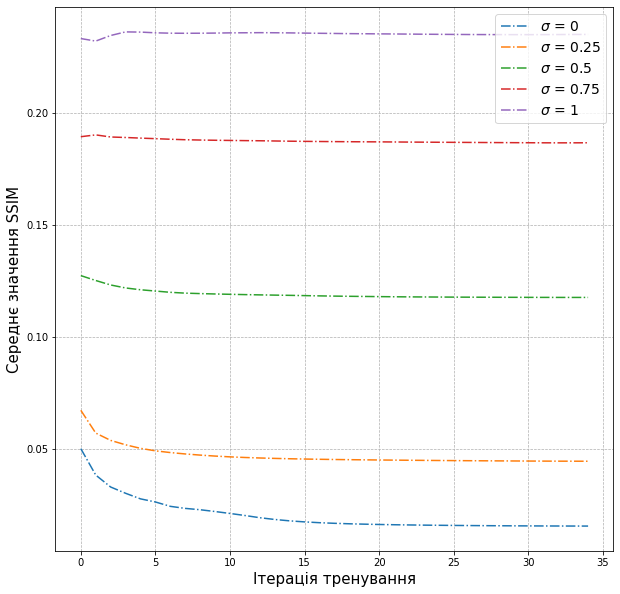

In [17]:
def compare_train_loss(awgn_training_results, figsize=(10, 10)):
  fig, ax = plt.subplots(figsize=figsize)

  for noise, res in awgn_training_results.items():
    ax.plot(res["train"], '-.', label=fr"$\sigma$ = {noise}")
    ax.set_xlabel("Ітерація тренування", fontsize=15)
    ax.set_ylabel("Середнє значення SSIM", fontsize=15)
    ax.legend(fontsize=14)
    ax.grid(linestyle='--', linewidth=0.7)
  
compare_train_loss(awgn_training_results)

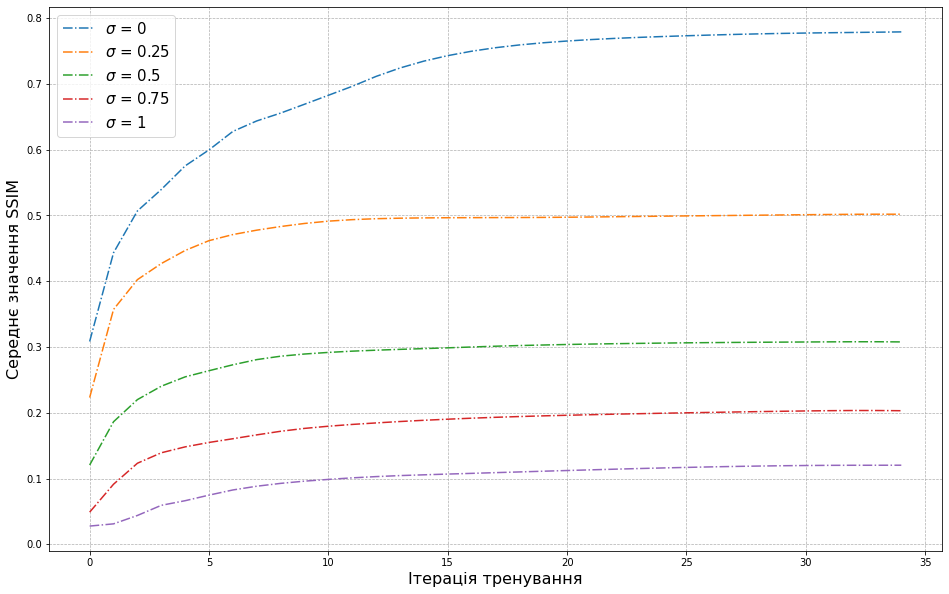

In [59]:
def compare_train_ssim(awgn_training_results, figsize=(16, 10)):  
  fig, ax = plt.subplots(figsize=figsize)

  for noise, res in awgn_training_results.items():
    ax.plot(res["ssim"], '-.', label=fr"$\sigma$ = {noise}")
    ax.set_xlabel("Ітерація тренування", fontsize=16)
    ax.set_ylabel("Середнє значення SSIM", fontsize=16)
    ax.legend(fontsize=15)
    ax.grid(linestyle='--', linewidth=0.7)
  
  fig.savefig("images/awgn-train-ssim-comparation.pdf", transparent=True, bbox_inches='tight', pad_inches=0)
  
compare_train_ssim(awgn_training_results)